<a href="https://colab.research.google.com/github/plaban1981/Pytorch/blob/master/pytorch_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch image classification with pre-trained networks

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-image-classification/pytorch-image-classification.zip
!unzip -qq pytorch-image-classification.zip
%cd pytorch-image-classification

--2022-03-20 13:08:01--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-image-classification/pytorch-image-classification.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.237.241
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.237.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2350600 (2.2M) [application/zip]
Saving to: ‘pytorch-image-classification.zip’

pytorch-image-class 100%[===================>]   2.24M  --.-KB/s    in 0.1s    

2022-03-20 13:08:01 (20.7 MB/s) - ‘pytorch-image-classification.zip’ saved [2350600/2350600]

/content/pytorch-image-classification


### Import Packages

In [2]:
# import the necessary packages
from matplotlib import pyplot as plt
from torchvision import models
import numpy as np
import argparse
import torch
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Creating our configuration file

In [4]:
class Config:
    # specify image dimension
    IMAGE_SIZE = 224

    # specify ImageNet mean and standard deviation
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    # determine the device we will be using for inference
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # specify path to the ImageNet labels
    IN_LABELS = "ilsvrc2012_wordnet_lemmas.txt"

# initialize a config object
config = Config()

### Implementing our image classification script

In [5]:
def preprocess_image(image):
	# swap the color channels from BGR to RGB, resize it, and scale
	# the pixel values to [0, 1] range
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (config.IMAGE_SIZE, config.IMAGE_SIZE))
	image = image.astype("float32") / 255.0

	# subtract ImageNet mean, divide by ImageNet standard deviation,
	# set "channels first" ordering, and add a batch dimension
	image -= config.MEAN
	image /= config.STD
	image = np.transpose(image, (2, 0, 1))
	image = np.expand_dims(image, 0)

	# return the preprocessed image
	return image

In [14]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to the input image")
#ap.add_argument("-m", "--model", type=str, default="vgg16",
#	choices=["vgg16", "vgg19", "inception", "densenet", "resnet"],
#	help="name of pre-trained network to use")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "images/boat.png",
	"model": "vgg16"
}

In [7]:
# define a dictionary that maps model names to their classes
# inside torchvision
MODELS = {
	"vgg16": models.vgg16(pretrained=True),
	"vgg19": models.vgg19(pretrained=True),
	"inception": models.inception_v3(pretrained=True),
	"densenet": models.densenet121(pretrained=True),
	"resnet": models.resnet50(pretrained=True)
}

# load our the network weights from disk, flash it to the current
# device, and set it to evaluation mode
#print("[INFO] loading {}...".format(args["model"]))
#model = MODELS[args["model"]].to(config.DEVICE)
#model.eval()

In [9]:
# load the preprocessed the ImageNet labels
print("[INFO] loading ImageNet labels...")
imagenetLabels = dict(enumerate(open(config.IN_LABELS)))

[INFO] loading ImageNet labels...


In [23]:
def process_image(image):
  print("[INFO] loading image...")
  image = cv2.imread(args["image"])
  orig = image.copy()
  image = preprocess_image(image)

  # convert the preprocessed image to a torch tensor and flash it to
  # the current device
  image = torch.from_numpy(image)
  image = image.to(config.DEVICE)
  return image,orig


In [34]:
def evaluate_models(model,name,orig,image):
  # classify the image and extract the predictions
  print("[INFO] classifying image with '{}'...".format(name))
  #print(model)
  logits = model(image)
  probabilities = torch.nn.Softmax(dim=-1)(logits)
  sortedProba = torch.argsort(probabilities, dim=-1, descending=True)
  
  # loop over the predictions and display the rank-5 predictions and
  # corresponding probabilities to our terminal
  for (i, idx) in enumerate(sortedProba[0, :5]):
    print("{}. {}: {:.2f}%".format(i, imagenetLabels[idx.item()].strip(),probabilities[0, idx.item()] * 100))

  # draw the top prediction on the image and display the image to
  # our screen
  (label, prob) = (imagenetLabels[probabilities.argmax().item()],probabilities.max().item())
  #print(label,prob)
  cv2.putText(orig, "Label: {}, {:.2f}%".format(label.strip(), prob * 100),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
  plt_imshow(f"Classification model used {name}", orig)

## classify the image and extract the predictions using diferrent trained Models

In [35]:
def processing(model,name,image):
  model = model.to(config.DEVICE)
  model.eval()
  processed_image,orig = process_image(image)
  evaluate_models(model,name,orig,processed_image)


[INFO] loading image...
[INFO] classifying image with 'vgg16'...
0. wreck: 99.99%
1. seashore, coast, seacoast, sea-coast: 0.01%
2. pirate, pirate_ship: 0.00%
3. breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.00%
4. sea_lion: 0.00%


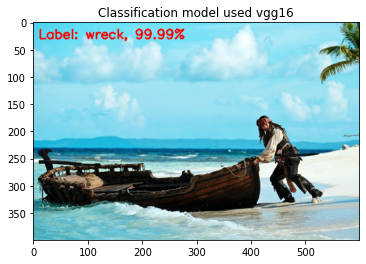

[INFO] loading image...
[INFO] classifying image with 'vgg19'...
0. wreck: 99.90%
1. pirate, pirate_ship: 0.03%
2. seashore, coast, seacoast, sea-coast: 0.02%
3. amphibian, amphibious_vehicle: 0.02%
4. breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.00%


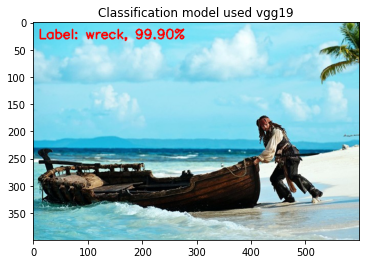

[INFO] loading image...
[INFO] classifying image with 'inception'...
0. wreck: 99.91%
1. pirate, pirate_ship: 0.01%
2. flat-coated_retriever: 0.01%
3. Labrador_retriever: 0.01%
4. colobus, colobus_monkey: 0.01%


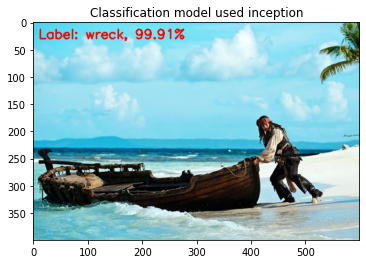

[INFO] loading image...
[INFO] classifying image with 'densenet'...
0. wreck: 96.54%
1. pirate, pirate_ship: 0.92%
2. breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.28%
3. seashore, coast, seacoast, sea-coast: 0.25%
4. sandbar, sand_bar: 0.16%


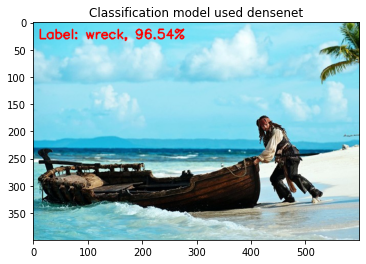

[INFO] loading image...
[INFO] classifying image with 'resnet'...
0. wreck: 99.51%
1. pirate, pirate_ship: 0.23%
2. seashore, coast, seacoast, sea-coast: 0.05%
3. breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.03%
4. amphibian, amphibious_vehicle: 0.02%


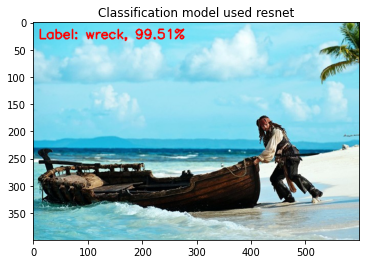

In [36]:
for name,model in MODELS.items():
  processing(model,name,args["image"])

[INFO] classifying image with 'vgg16'...
0. wreck: 99.99%
1. seashore, coast, seacoast, sea-coast: 0.01%
2. pirate, pirate_ship: 0.00%
3. breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.00%
4. sea_lion: 0.00%


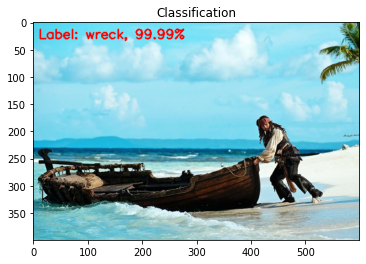

In [9]:
# classify the image and extract the predictions
print("[INFO] classifying image with '{}'...".format(args["model"]))
logits = model(image)
probabilities = torch.nn.Softmax(dim=-1)(logits)
sortedProba = torch.argsort(probabilities, dim=-1, descending=True)

# loop over the predictions and display the rank-5 predictions and
# corresponding probabilities to our terminal
for (i, idx) in enumerate(sortedProba[0, :5]):
	print("{}. {}: {:.2f}%".format
		(i, imagenetLabels[idx.item()].strip(),
		probabilities[0, idx.item()] * 100))

# draw the top prediction on the image and display the image to
# our screen
(label, prob) = (imagenetLabels[probabilities.argmax().item()],
	probabilities.max().item())
cv2.putText(orig, "Label: {}, {:.2f}%".format(label.strip(), prob * 100),
	(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
plt_imshow("Classification", orig)